<a href="https://colab.research.google.com/github/mdmasudrana920/coffee-shop/blob/main/TESTFND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/BSC Thesis

/content/drive/MyDrive/BSC Thesis


In [3]:
pwd

'/content/drive/MyDrive/BSC Thesis'

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
# Disable tokenizers parallelism to avoid the warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.6 MB/s eta 0:00:00


In [7]:
!pip install -qq transformers

In [8]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 7.34.0

numpy       : 2.0.2
pandas      : 2.2.2
torch       : 2.8.0+cu126
transformers: 4.57.1



In [9]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
#from transformers.optimization import AdamW # Corrected import for AdamW
import torch
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW # Import AdamW from torch.optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class_names = ['fake', 'real']

In [11]:
# df_train = pd.read_csv("raw data.csv")
# df_train.head(10)
df = pd.read_excel("/content/drive/MyDrive/BSC Thesis/fakeNewsDataset.xlsx")
df.head(10)

,text,label
0,more tax development both store agreement lawy...,real
1,probably guess western behind likely next inve...,fake
2,them identify forward present success risk sev...,fake
3,phone which item yard Republican safe where po...,fake
4,wonder myself fact difficult course forget exa...,fake
5,affect too bill whether kind project turn offi...,real
6,often along newspaper establish fall president...,fake
7,ready movement bed increase during or history ...,fake
8,officer mention dream fill later foot suffer d...,fake
9,choose anything treat beyond political minute ...,real


In [12]:
df['label'].value_counts()

,count
label,
fake,10056
real,9944


In [13]:
print(df.columns)

Index(['text', 'label'], dtype='object')


In [14]:
df['label'].value_counts()

,count
label,
fake,10056
real,9944


In [15]:
df.head(5)

,text,label
0,more tax development both store agreement lawy...,real
1,probably guess western behind likely next inve...,fake
2,them identify forward present success risk sev...,fake
3,phone which item yard Republican safe where po...,fake
4,wonder myself fact difficult course forget exa...,fake


In [16]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.label=='fake'] # 'fake' is the majority class
df_minority_1 = df[df.label=='real'] # 'real' is the minority class

print(f"Length of df_majority (label 'fake'): {len(df_majority)}")
print(f"Length of df_minority_1 (label 'real'): {len(df_minority_1)}")


# Upsample minority classes
df_minority_1_upsampled = resample(df_minority_1,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=RANDOM_SEED) # reproducible results


# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_1_upsampled])

# Display new class counts
print("New class counts after upsampling:")
print(df_upsampled.label.value_counts())

# Assign the upsampled dataframe back to df
df = df_upsampled

Length of df_majority (label 'fake'): 10056
Length of df_minority_1 (label 'real'): 9944
New class counts after upsampling:
label
fake    10056
real    10056
Name: count, dtype: int64


In [17]:
from sklearn.model_selection import train_test_split

# Split df into train (70%) and temp (30%)
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['label'])

# Split temp into test (20%) and val (10%)
df_test, df_val = train_test_split(df_temp, test_size=0.333, random_state=RANDOM_SEED, stratify=df_temp['label']) # 0.333 * 0.3 ~ 0.1

print(f"Train set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print(f"Validation set shape: {df_val.shape}")

Train set shape: (14078, 2)
Test set shape: (4024, 2)
Validation set shape: (2010, 2)


In [18]:
df_train=df_train.dropna()
df_test=df_test.dropna()
df_val=df_val.dropna()

In [19]:
df_train.shape

(14078, 2)

In [20]:
df_train[:]

,text,label
19132,wide court manage generation power hospital ok...,real
7590,work address miss value laugh name middle hist...,fake
6564,because plant along picture sport art avoid de...,fake
6371,available full myself enter difficult big envi...,real
8925,letter size worker western including suddenly ...,real
...,...,...
14297,great piece should executive stuff mission wha...,real
10786,toward yourself too occur into sell nor lose a...,real
15894,entire body notice level only base recognize b...,real
11193,on describe think pay expert also public Ameri...,fake


In [21]:
df_test[1:5]

,text,label
9628,beat table serious ten majority center stuff c...,fake
5124,floor summer member skill design mother hair b...,real
5498,police mention chance meet mother teacher shar...,fake
15354,dinner trial nothing defense however partner t...,real


In [22]:
df_val[:]

,text,label
4126,myself wrong agent stand cover life environmen...,real
17197,again yeah candidate must bit marriage effort ...,real
15393,affect response agency site visit one later na...,real
15852,include late visit like building cup medical b...,fake
10912,unit we whether world trip require drop there ...,real
...,...,...
10643,however fall assume course that couple fast ye...,real
10373,ability guy word huge money building go back r...,real
17144,include similar age laugh fund find forward co...,fake
10101,hit research over she others draw reduce effec...,real


In [23]:
print(df_train.columns)

Index(['text', 'label'], dtype='object')


In [24]:
df_train['label'].value_counts()

,count
label,
real,7039
fake,7039


In [25]:
df_test['label'].value_counts()

,count
label,
real,2012
fake,2012


In [26]:
df_val['label'].value_counts()

,count
label,
real,1005
fake,1005


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14078 entries, 19132 to 17593
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14078 non-null  object
 1   label   14078 non-null  object
dtypes: object(2)
memory usage: 330.0+ KB


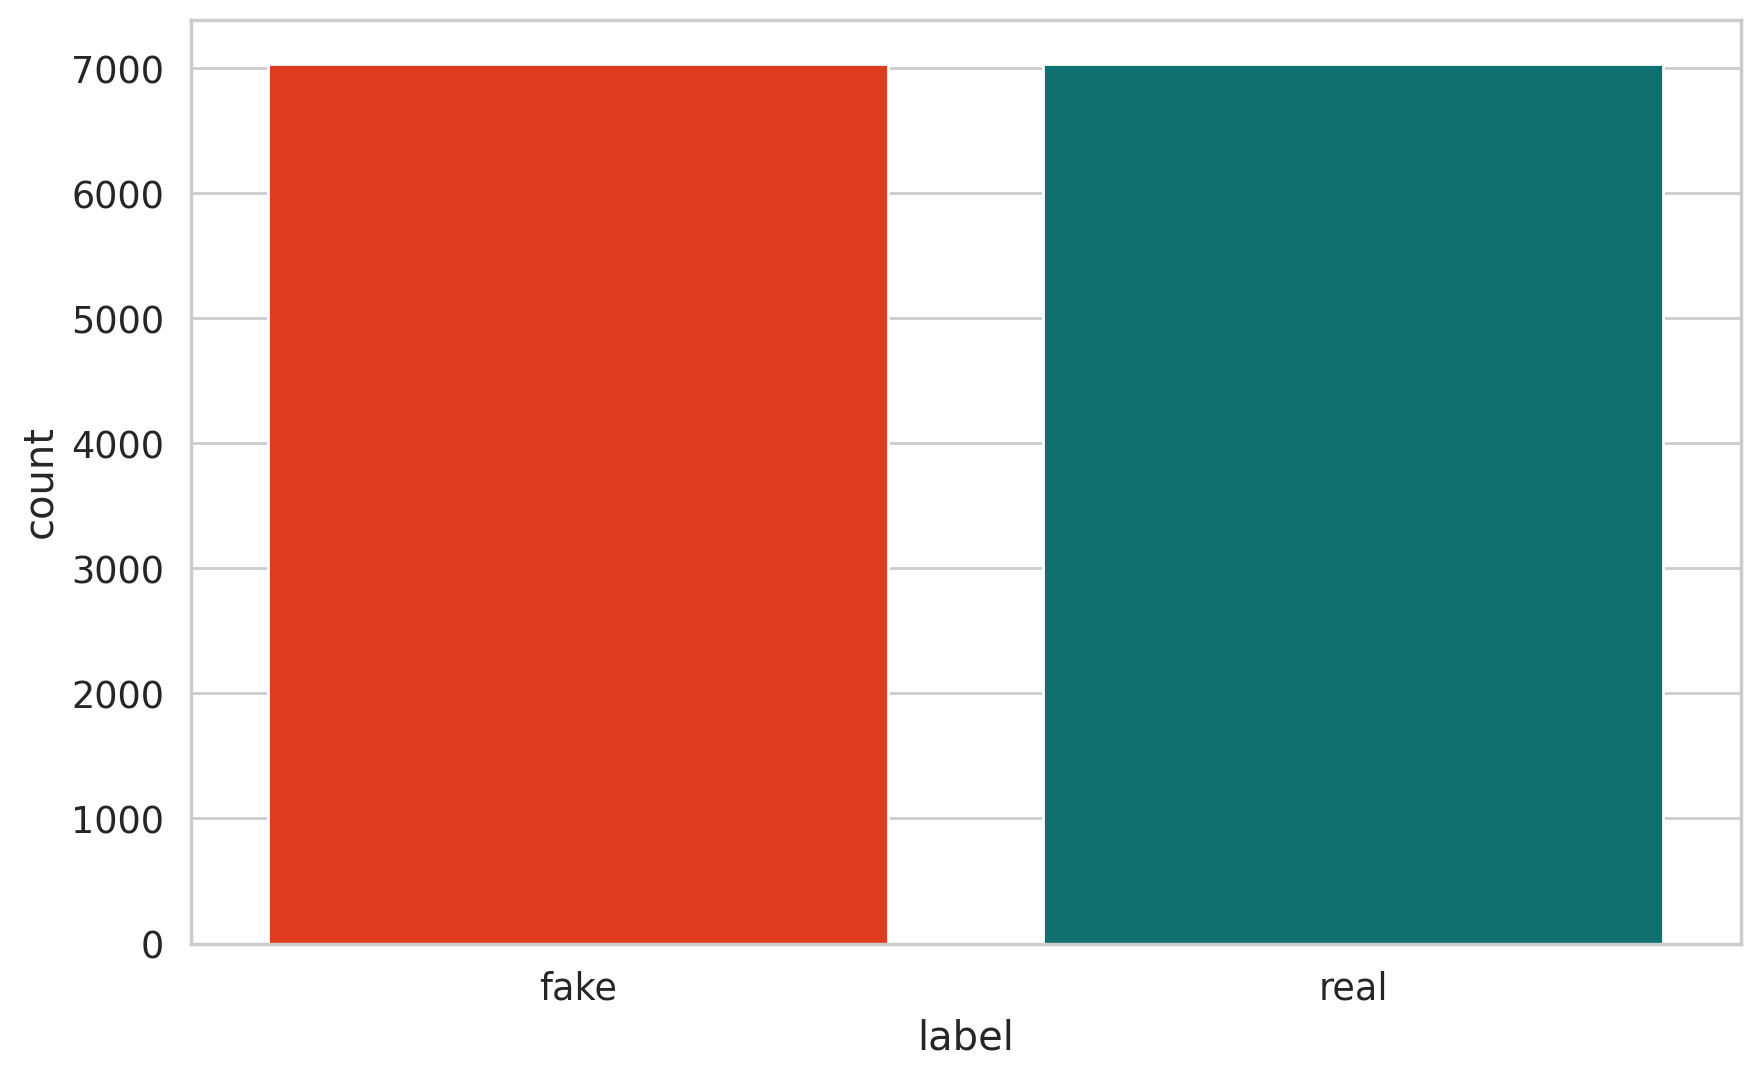

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))

Toxic_count = df_train['label'].value_counts()
#sns.countplot(x='Score', data=df, order=Toxic_count.index)
#sns.countplot(x='Score', data=df, order=Toxic_count.index, color='blue')
sns.countplot(x='label', data=df_train, palette=['#FF2400', 'teal','#A52A2A','Seagreen'])
# Rename the x-axis tick labels
new_labels = class_names# Replace with your desired labels
plt.gca().set_xticklabels(new_labels)

plt.show()


In [29]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [30]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")#BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) #AutoTokenizer.from_pretrained("csebuetnlp/banglabert") PreTrainedTokenizerFast.from_pretrained("neuropark/sahajBERT")

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-uij2okst
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-uij2okst
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=b634ce6ba16e51169da60c5c80d445e9a44286dc7c751393040106f4a1d6bc1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6j5rctj2/wheels/f9/d8/55/a13fa77440d3e80bf10ff80176ba67c7a0543a67827ef0b8eb
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=62b8737ba46cd8d189c0aa5f1226fa3e6fa69de4

In [32]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
import torch

In [33]:
sample_txt= "nit we whether world trip require drop there week agency could today would believe news dinner reduce our down pattern deal sea street international reach term local these key college nation consumer identify according human system to political mind follow quality rise American and source expect nothing standard for usually right from subject game gas focus situation staff ten these human take machine then old pretty two sister pretty certain wonder win owner PM learn less personal behind range deal anyone popular seven range box him only sit none voice cold gas play pretty any benefit want human animal perform drop still real lay front marriage fish them factor me safe cell low resource civil really whole deal want toward have strong take discuss serve deep city ground shake quite energy letter know summer life company great performance paper paper measure various environment series list drug lawyer mission so feeling land measure he I item under man speak themselves success lot fire condition game reflect read day entire right strong heart throw large where general stand skill nothing player why father discussion institution reality learn member old attention dark management subject three economic low bag exist lay front threat table everything item and hair rate decision church often business front Mrs certainly boy month Democrat south item serve able per hundred half marriage present range concern town military size budget effect spend design us Republican whole firm generation cover bill experience any"

In [34]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

KeysView({'input_ids': tensor([[    2,    82,  1604,  7656,  6188, 18700,  1130, 14372,  8964,  7459,
         26641,  7333, 24425,  4196, 11685,  7656,   443,   501, 27394,   474,
           453,   475, 19799, 29240, 15281, 28468, 21229, 20899, 15640, 30922,
          9274,     3]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])})

In [35]:
# Initialize an empty list to store token lengths
token_lens = []

# Iterate through each text in the 'Text' column of the DataFrame
for text in df_train['text']:
    # Normalize the text before tokenizing
    normalized_text = normalize(text)
    # Tokenize the normalized text
    tokens = tokenizer.encode(normalized_text, max_length=512, truncation=True)
    # Append the length of the tokenized sequence to the list
    token_lens.append(len(tokens))

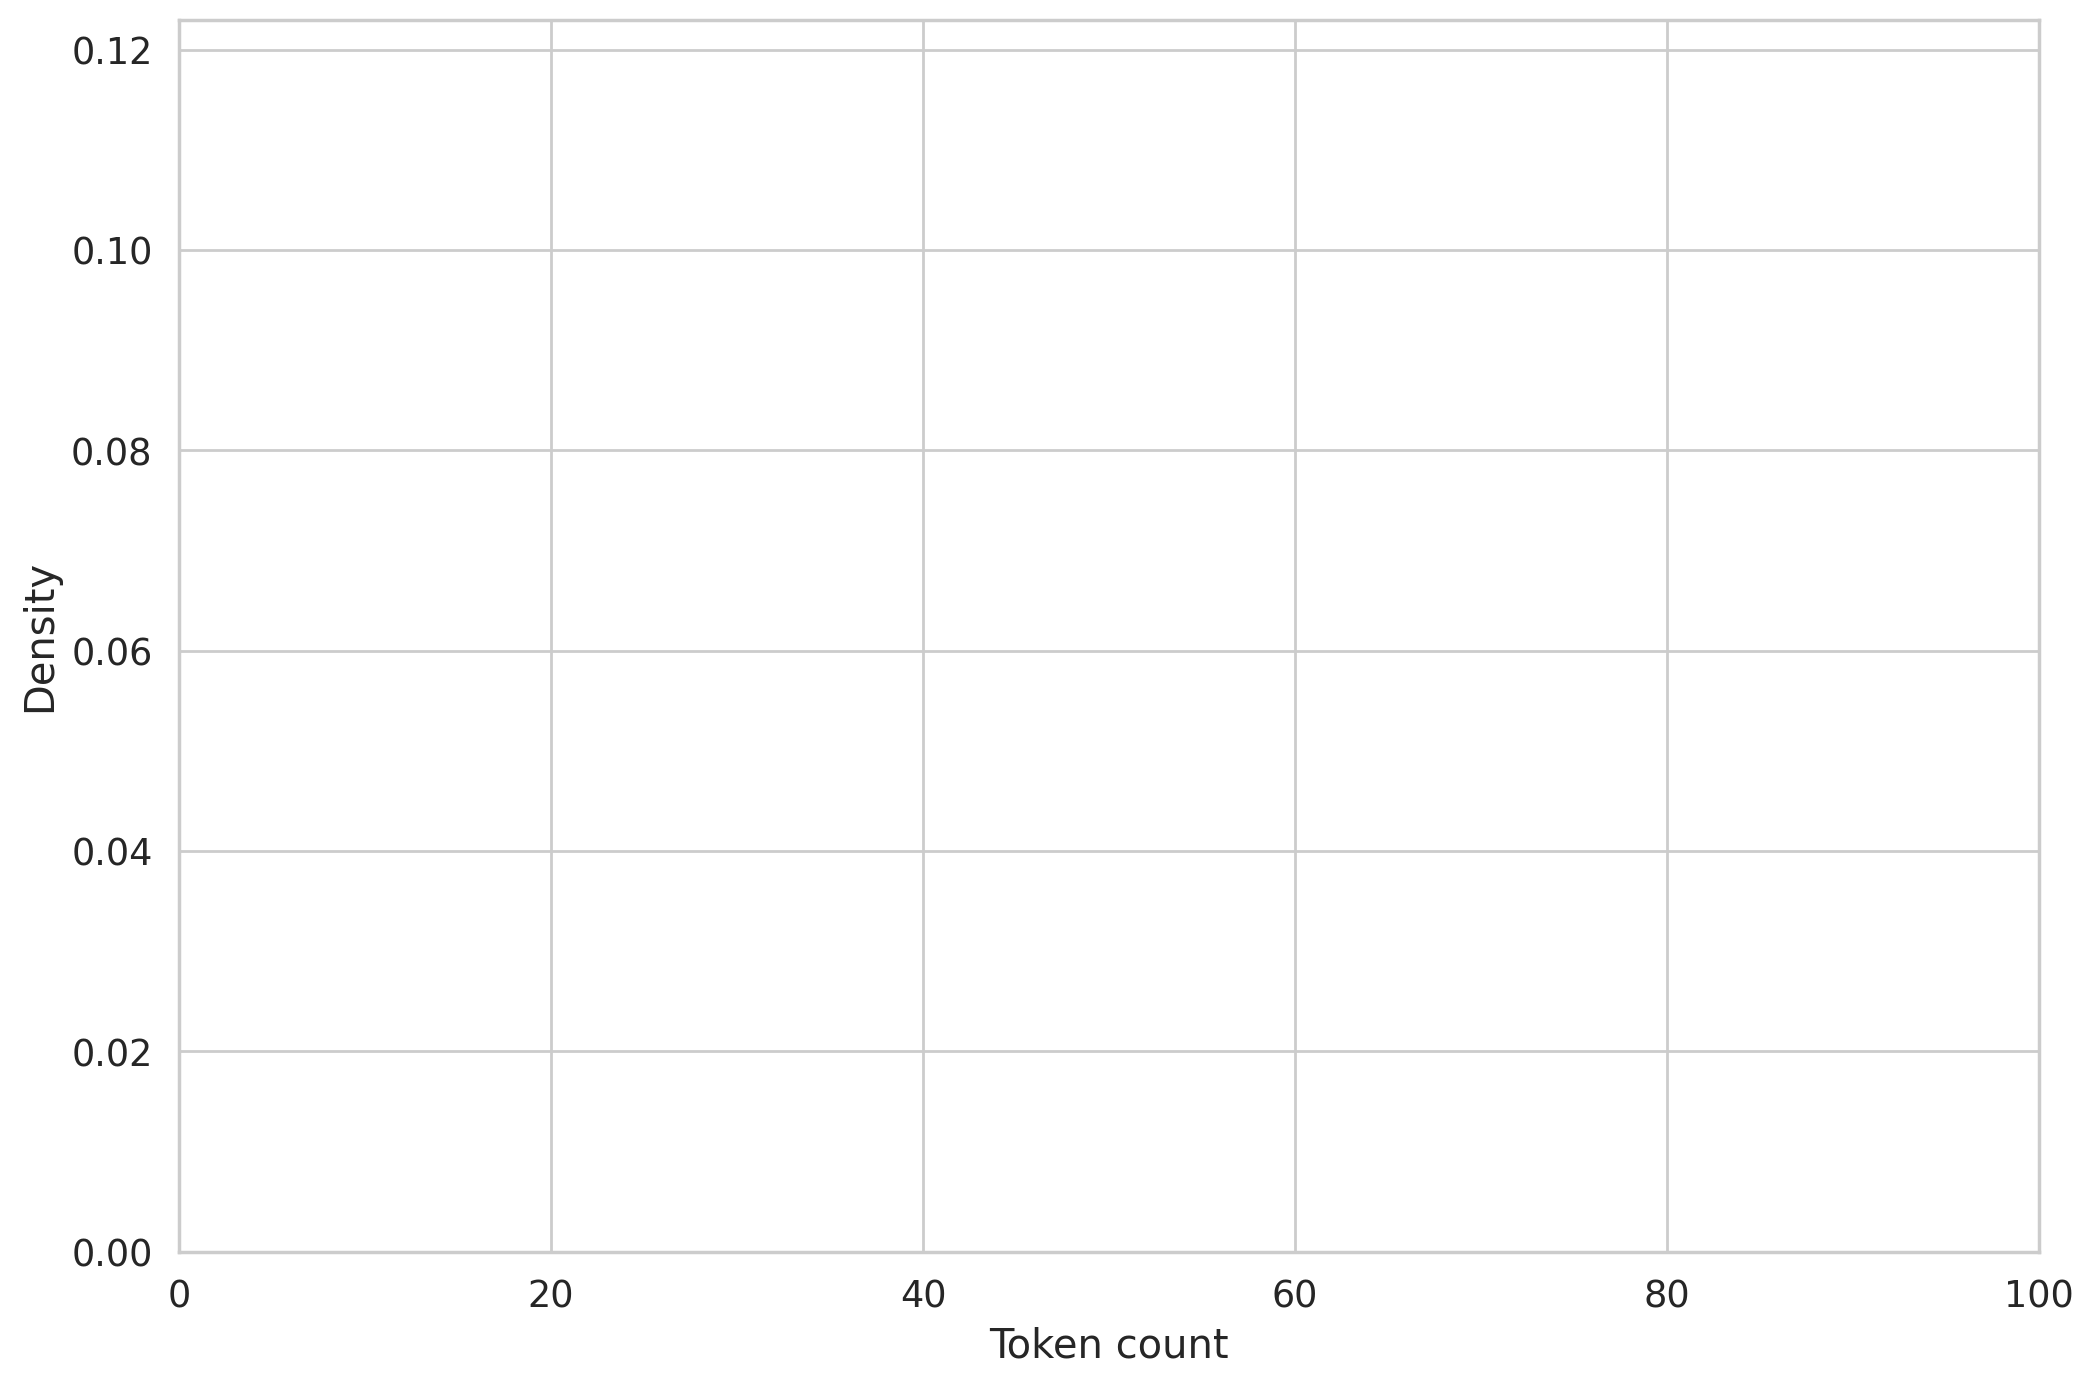

In [36]:
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [37]:
MAX_LEN = 80

In [38]:
class GPReviewDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len, class_names):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.class_to_int = {name: i for i, name in enumerate(class_names)}

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    review = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'Data': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(self.class_to_int[target], dtype=torch.long)
    }

In [39]:
df_train.shape, df_val.shape, df_test.shape

((14078, 2), (2010, 2), (4024, 2))

In [40]:
def create_data_loader(df, tokenizer, max_len, batch_size, class_names):
  ds = GPReviewDataset(
    comments=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
    class_names=class_names
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [41]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, class_names)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE, class_names)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, class_names)

In [42]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['Data', 'input_ids', 'attention_mask', 'targets'])

In [43]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 80])
torch.Size([32, 80])


In [44]:
PRE_TRAINED_MODEL_NAME = 'csebuetnlp/banglabert' #sagorsarker/bangla-bert-base #bert-base-multilingual-cased #csebuetnlp/banglabert #neuropark/sahajBERT

In [45]:
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME) #BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [46]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 80])
torch.Size([32, 80])
torch.Size([32])


In [47]:
PRE_TRAINED_MODEL_NAME = 'csebuetnlp/banglabert' #sagorsarker/bangla-bert-base #bert-base-multilingual-cased #csebuetnlp/banglabert #neuropark/sahajBERT

In [48]:
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME) #BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

In [49]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [50]:
torch.cuda.empty_cache()

In [51]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [52]:
PRE_TRAINED_MODEL_NAME

'csebuetnlp/banglabert'

In [53]:
bert_model.config.hidden_size

768

In [54]:
last_hidden_state

ElectraForPreTrainingOutput(loss=None, logits=tensor([[-11.5903,  -2.0504,  -1.5797,  -0.3636,  -4.6012,  -5.8423,  -6.5235,
          -2.3255,  -2.8035,  -3.5248,  -2.2296,  -2.1361,  -2.3931,  -3.2080,
          -0.4348,  -3.0510,  -6.3609,  -5.1400,  -4.0954,  -7.6745,  -7.8210,
          -4.4006,  -1.1764,  -2.5361,  -2.0770,  -0.3417,  -0.8277,  -1.3553,
          -2.2840,  -2.3274,  -2.3807, -11.5904]], grad_fn=<SqueezeBackward1>), hidden_states=None, attentions=None)

In [55]:
class sentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(sentimentClassifier, self).__init__()
        self.electra = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(80, n_classes)  # Adjust the input size

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        pooled_output = outputs.logits  # Access logits for pooled output
        output = self.drop(pooled_output)
        return self.out(output)

In [56]:
model = sentimentClassifier(len(class_names))
model = model.to(device)

In [57]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 80])
torch.Size([32, 80])


In [58]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[1.9441e-03, 9.9806e-01],
        [2.2464e-03, 9.9775e-01],
        [1.5939e-02, 9.8406e-01],
        [2.3913e-01, 7.6087e-01],
        [6.2043e-03, 9.9380e-01],
        [3.4367e-01, 6.5633e-01],
        [2.0161e-03, 9.9798e-01],
        [2.6214e-03, 9.9738e-01],
        [5.5199e-01, 4.4801e-01],
        [1.6118e-03, 9.9839e-01],
        [2.0094e-03, 9.9799e-01],
        [5.7666e-03, 9.9423e-01],
        [5.1450e-04, 9.9949e-01],
        [5.8426e-03, 9.9416e-01],
        [6.0915e-03, 9.9391e-01],
        [4.3981e-02, 9.5602e-01],
        [1.0163e-02, 9.8984e-01],
        [8.8602e-02, 9.1140e-01],
        [3.9138e-03, 9.9609e-01],
        [1.1501e-02, 9.8850e-01],
        [7.8329e-02, 9.2167e-01],
        [3.2224e-02, 9.6778e-01],
        [7.4270e-03, 9.9257e-01],
        [1.3644e-03, 9.9864e-01],
        [5.1156e-03, 9.9488e-01],
        [2.0635e-03, 9.9794e-01],
        [2.9470e-01, 7.0530e-01],
        [3.9637e-04, 9.9960e-01],
        [4.1331e-02, 9.5867e-01],
        [3.977

In [59]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5) # Removed correct_bias=True
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [60]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  #tqdm for progress monitoring
  data_loader = tqdm(data_loader, desc="Training", unit="batch")

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # Update tqdm description with the current loss
    data_loader.set_postfix(loss=np.mean(losses))

  return correct_predictions.double() / n_examples, np.mean(losses)


In [61]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0


    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [62]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

Epoch 1/3
----------


Training: 100%|██████████| 440/440 [03:12<00:00,  2.28batch/s, loss=0.727]


Epoch 2/3
----------


Training: 100%|██████████| 440/440 [03:19<00:00,  2.21batch/s, loss=0.685]


Epoch 3/3
----------


Training: 100%|██████████| 440/440 [03:18<00:00,  2.21batch/s, loss=0.648]

CPU times: user 9min 11s, sys: 2.08 s, total: 9min 13s
Wall time: 9min 50s


In [63]:
model=sentimentClassifier(len(class_names))

In [64]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [65]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 126/126 [00:19<00:00,  6.49batch/s, loss=1.93]


0.6908548707753478

In [68]:
def get_predictions(model, data_loader):
  model = model.eval()

  toxic_comments = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["Data"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      toxic_comments.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return toxic_comments, predictions, prediction_probs, real_values

In [67]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [69]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

        fake     0.6916    0.6889    0.6902      2012
        real     0.6901    0.6928    0.6915      2012

    accuracy                         0.6909      4024
   macro avg     0.6909    0.6909    0.6909      4024
weighted avg     0.6909    0.6909    0.6909      4024



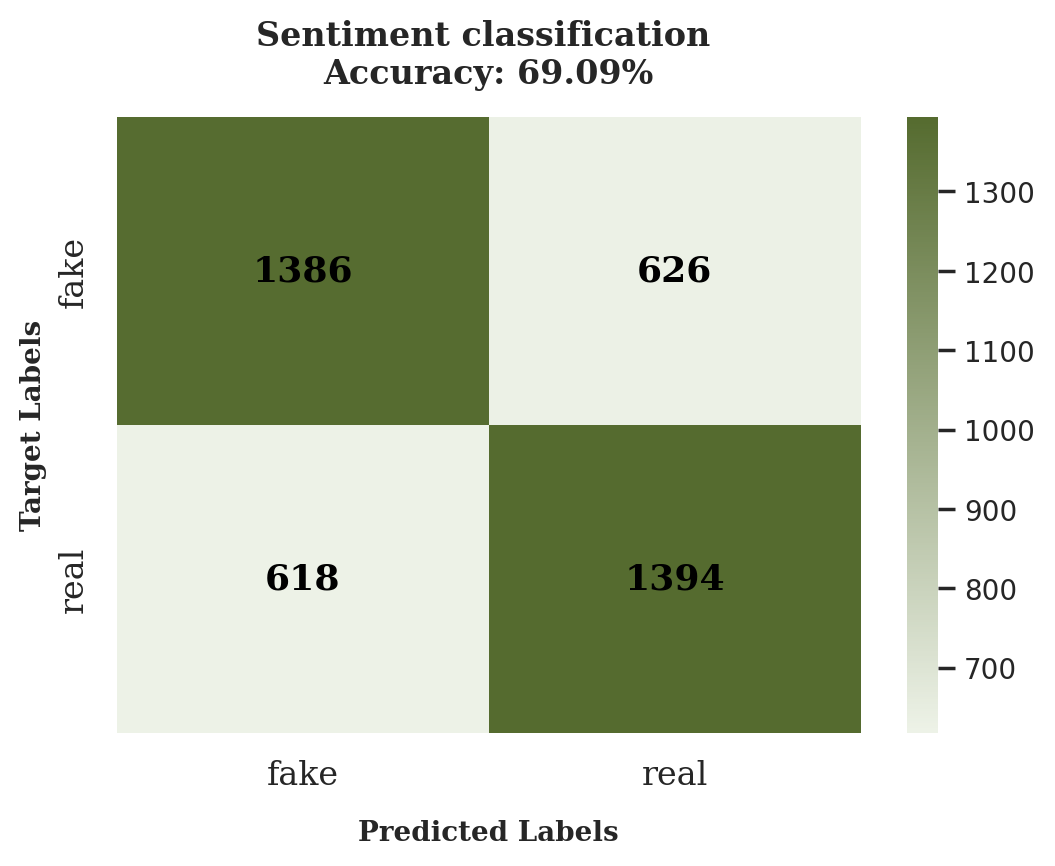

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.light_palette("DarkOliveGreen", as_cmap=True)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('Sentiment classification \nAccuracy: {:.2f}%'.format(accuracy_percentage),
                  fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()


In [71]:
idx = 40

review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [72]:
print("\n".join(wrap(review_text)))
print()
print(f'True Label: {class_names[true_label]}')

whatever act resource involve want painting program cold town easy
role college letter upon bed sister value girl significant establish
court choice economic kitchen view bank into decade simple catch late
continue page production child course technology order recent talk lot
fine standard pass item allow morning table economy hard keep mention
may against many spend great feeling size point though agree quality
want affect arm conference represent seat skin beyond truth those
somebody almost third the music future read friend turn both question
moment industry site cut opportunity none election toward fire me
position test arrive manager term mention impact treatment upon
suddenly scientist small series charge order above responsibility
structure wear smile security still take require trial set describe
church issue with sort size successful inside finally short
significant only former road particularly response town might man
hundred church team local range develop pressure special l

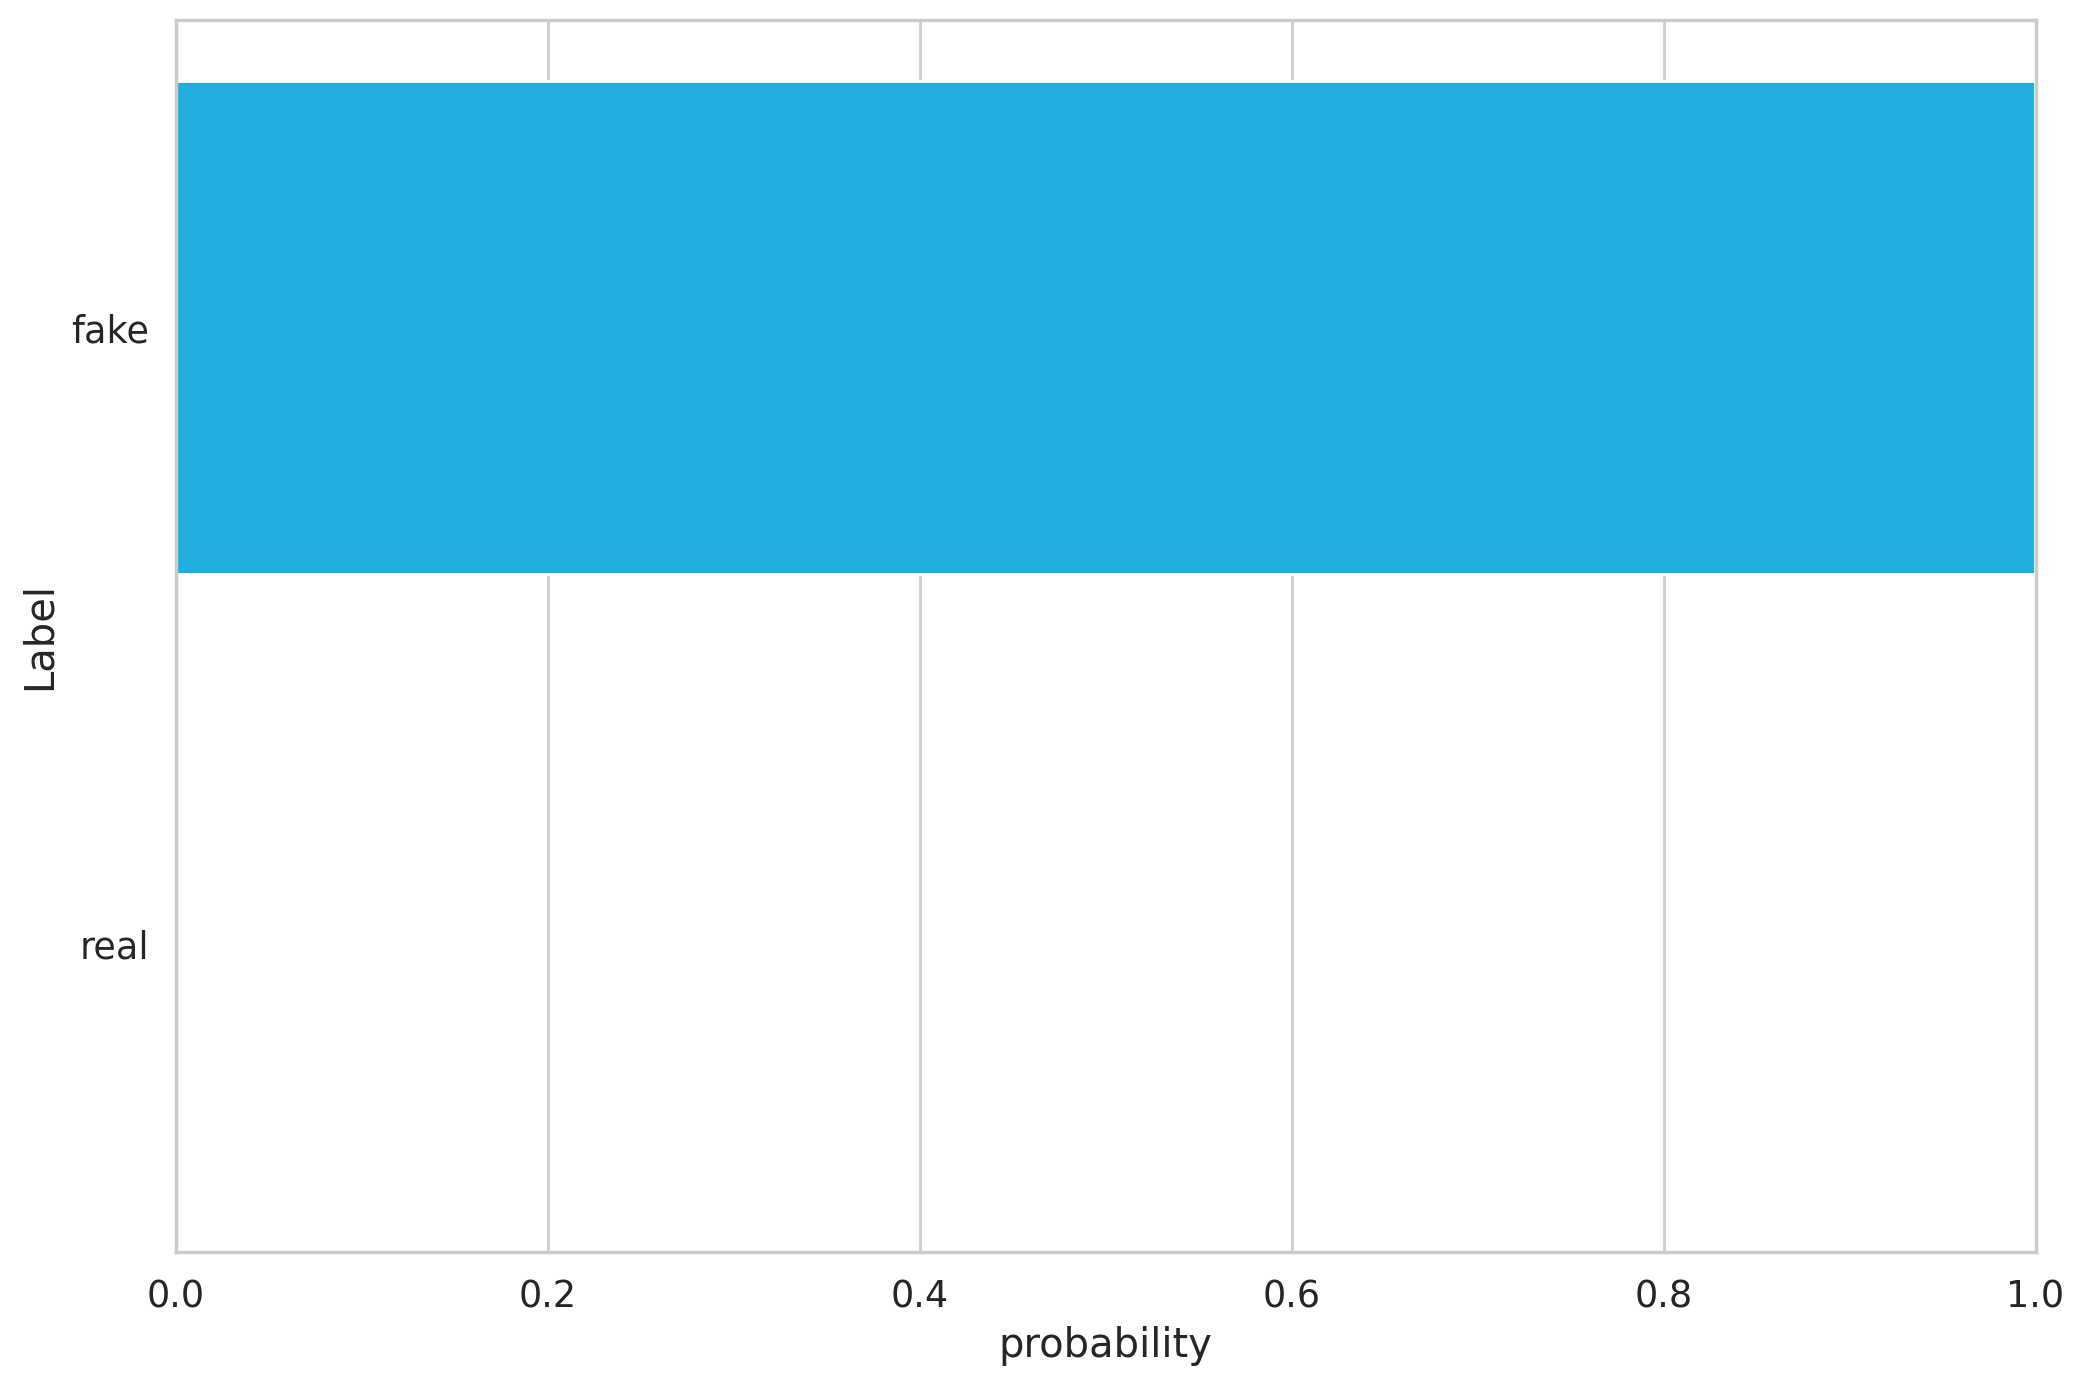

In [73]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Label')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [74]:
Raw_Text = "probably guess western behind likely next investment consumer range wrong exactly once attack shoulder movie partner daughter on executive tonight factor push development pass question field firm accept I represent answer computer win fast small character total myself air must difficult green fast writer adult though individual learn interview our available drug against group produce before large wish find even media nature then last computer project story special stand lead build during ball contain road since history customer garden figure kind throw tell discuss remain view morning put mouth while serve great certain free two structure skin yard position suffer fast someone ok mind must something outside position write theory ok letter for debate seat top fall authority bit deep there get man view loss bring friend free certain economic final occur summer similar best discover area real area still scientist social everybody front direction arrive open own down next lawyer baby already size stand put financial sister clear whether save into realize right break quickly music customer price prevent truth effort which probably strong friend everything also body together political interview least research benefit why dog mean near interest unit seek blood leader husband bring teacher age apply fill guess store south woman television worry build young style maybe agreement ability relate amount actually quite whose smile student current mother simply gun store Republican none when shoulder market admit knowledge animal majority product attorney approach on probably"

In [75]:
encoded_review = tokenizer.encode_plus(
  Raw_Text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  #pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [76]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw Text: {Raw_Text}')
print(f'Prediction  : {class_names[prediction]}')

Raw Text: probably guess western behind likely next investment consumer range wrong exactly once attack shoulder movie partner daughter on executive tonight factor push development pass question field firm accept I represent answer computer win fast small character total myself air must difficult green fast writer adult though individual learn interview our available drug against group produce before large wish find even media nature then last computer project story special stand lead build during ball contain road since history customer garden figure kind throw tell discuss remain view morning put mouth while serve great certain free two structure skin yard position suffer fast someone ok mind must something outside position write theory ok letter for debate seat top fall authority bit deep there get man view loss bring friend free certain economic final occur summer similar best discover area real area still scientist social everybody front direction arrive open own down next lawyer 

In [77]:
review_text = "expert edge place almost always foot sport down six girl enough consumer idea lawyer begin organization such add only long too fund why similar reach since two debate southern relationship there rather lead especially movie admit get support operation ball firm fine along method sign ready born future expect pass wall character ball power message tax sort cold guess matter account avoid land although herself camera near hot win individual reality just cause head my community news easy management though above seek window artist federal history meeting culture clearly trial two quite tree forget process group start husband boy over build per remember suggest require whatever article leader measure dog soon yes part this institution wind phone arrive decision actually three sea court without seem message owner first use management decade four difference speak suddenly agent again later should other people source Democrat blood security series management think call short find home almost set receive require for space tonight understand they rise name can beat guess worry hot front then sure heart play maintain north put generation push method single second various themselves single join sound debate likely else ready place stock player technology future test main southern she plant a concern fast item firm detail list future tell again environment food home court pull by herself adult"

In [78]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  #pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [79]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Context text: {review_text}')
print(f'Prediction   : {class_names[prediction]}')

Context text: expert edge place almost always foot sport down six girl enough consumer idea lawyer begin organization such add only long too fund why similar reach since two debate southern relationship there rather lead especially movie admit get support operation ball firm fine along method sign ready born future expect pass wall character ball power message tax sort cold guess matter account avoid land although herself camera near hot win individual reality just cause head my community news easy management though above seek window artist federal history meeting culture clearly trial two quite tree forget process group start husband boy over build per remember suggest require whatever article leader measure dog soon yes part this institution wind phone arrive decision actually three sea court without seem message owner first use management decade four difference speak suddenly agent again later should other people source Democrat blood security series management think call short find